In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import glob

In [2]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.gradients = None
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),  
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),  
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(9216, 1028),
            nn.PReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(1028, 128),
            nn.PReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(128, 4),
            nn.PReLU(),
        )


    def forward(self, x): 
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward_with_hook(self, x):
        cl = self.conv_layer[:10]
        x = cl(x)
        
        h = x.register_hook(self.activations_hook)
    
        x = self.max_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.conv_layer(x)

In [3]:
PATH = "./CNNmodule1"
net = CNN()
net.load_state_dict(torch.load(PATH))
net

CNN(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=9216, out_features=102

In [4]:

class CDataset(Dataset):
    def __init__(self, train = False, test = False):

        self.data_path = "./data/heatmaps/"
        self.folder_list = glob.glob(self.data_path + "*")

        self.data = []
        for folder in self.folder_list:
            folder_name = folder.split("\\")[-1]
            for img_path in glob.glob(self.data_path + folder_name + "/*.jpg"):
                self.data.append([img_path, folder_name])
        self.class_map = {"Car": 0, "Truck": 1, "Bicycle": 2, "Dog": 3}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        img_path, class_name = self.data[i]
        img = cv2.imread(img_path)
        class_id = self.class_map[class_name]
        img_tensor = torch.tensor(img, dtype=torch.float)
        img_tensor = img_tensor.permute(2,0,1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

    
test_dataset = CDataset()
data_loader_test = DataLoader(test_dataset, batch_size=1, shuffle=False)

img = test_dataset.__getitem__(0)[0].unsqueeze(0)
label = test_dataset.__getitem__(0)[1]
label


tensor([1])

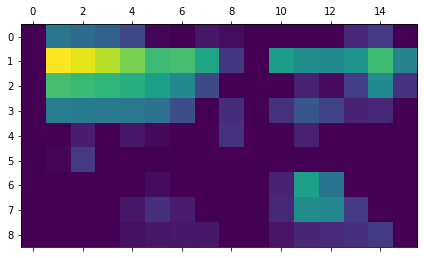

In [5]:
net.eval()

pred = net.forward_with_hook(img)
pred_index = pred.argmax(dim=1)

pred[:, pred_index].backward()
gradients = net.get_activations_gradient()

pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

activations = net.get_activations(img).detach()

for i in range(activations.size(1)):
    activations[:, i, :, :] *= pooled_gradients[i]
    
heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)

plt.matshow(heatmap.squeeze())

In [6]:
heatmap = heatmap.numpy()

plt.show()
img = cv2.imread('./Data/heatmaps/Truck/truck73.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True